In [1]:
import torch
import torch.nn as nn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
import requests
import zipfile
from pathlib import Path

# setup path to data folder 
data_path = Path("DATA")
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
    print(f'{image_path} directory exists')
    
else:
    print(f"Didn't find {image_path} directory, creating one")
    image_path.mkdir(parents=True,exist_ok=True)
    # download data
    with open(data_path/"pizza_steak_sushi.zip",'wb') as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print('Dowloading pizza, sushi, steak data ...')
        f.write(request.content)
    # Unzip data
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", 'r') as zip_ref:
        print(" Unzipiing pizza, steak, sushi data ...")
        zip_ref.extractall(image_path)

Didn't find DATA/pizza_steak_sushi directory, creating one
Dowloading pizza, sushi, steak data ...
 Unzipiing pizza, steak, sushi data ...


In [5]:
# walk through the directory 
import os
for dirpath, dirname, filenames in os.walk(image_path):
    print(f" There are {len(dirname)} directories and {len(filenames)} images in {dirpath}")

 There are 2 directories and 0 images in DATA/pizza_steak_sushi
 There are 3 directories and 0 images in DATA/pizza_steak_sushi/test
 There are 0 directories and 25 images in DATA/pizza_steak_sushi/test/pizza
 There are 0 directories and 19 images in DATA/pizza_steak_sushi/test/steak
 There are 0 directories and 31 images in DATA/pizza_steak_sushi/test/sushi
 There are 3 directories and 0 images in DATA/pizza_steak_sushi/train
 There are 0 directories and 78 images in DATA/pizza_steak_sushi/train/pizza
 There are 0 directories and 75 images in DATA/pizza_steak_sushi/train/steak
 There are 0 directories and 72 images in DATA/pizza_steak_sushi/train/sushi


In [6]:
# setup train and test paths 
train_dir = image_path/'train'
test_dir = image_path/'test'

train_dir,test_dir

(PosixPath('DATA/pizza_steak_sushi/train'),
 PosixPath('DATA/pizza_steak_sushi/test'))

sushi


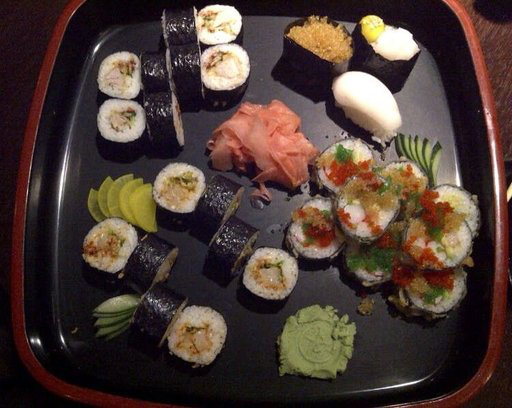

In [21]:
import random
from PIL import Image

# let's open a random image 
random.seed(42)
image_path_list = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(image_class)
img

In [27]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()])

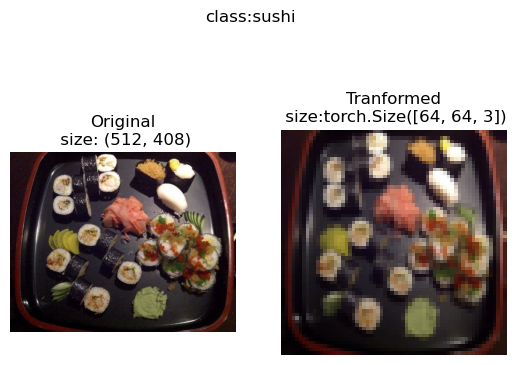

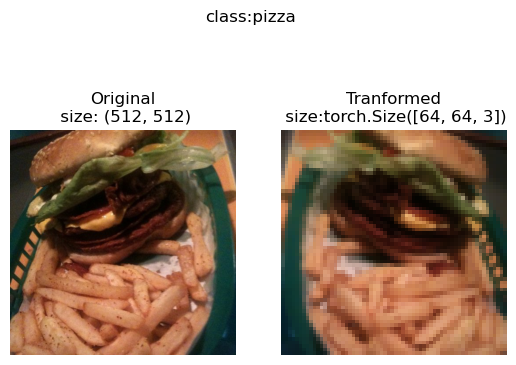

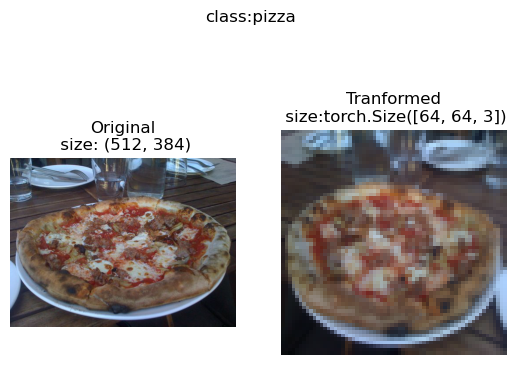

In [30]:
import matplotlib.pyplot as plt
random.seed(42)
random_image_paths = random.sample(image_path_list,k=3)

for image_path in random_image_paths:
    with Image.open(image_path) as f:
        # origianl image 
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(f)
        ax[0].set_title(f'Original\n size: {f.size}')
        ax[0].axis('off')
        # transformed image 
        transformed_image = data_transform(f).permute(1,2,0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f'Tranformed\n size:{transformed_image.shape}')
        ax[1].axis('off')
        
        fig.suptitle(f'class:{image_path.parent.stem}',fontsize=12)
        
        

In [32]:
# use image folder to create datasets

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform,target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,transform=data_transform)

In [34]:
# inspect the dataset we jusst created 

class_names = train_data.classes
print(class_names)
len(train_data),len(test_data)

['pizza', 'steak', 'sushi']


(225, 75)

In [38]:
# inspect one image (for Ex. first one in the train data)

img, label = train_data[0][0], train_data[0][1]
img.shape, label

(torch.Size([3, 64, 64]), 0)

In [39]:
# turn train and test datasets to data loaders 

from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,batch_size=1,num_workers=1,shuffle=True)
test_dataloader = DataLoader(dataset=test_data,batch_size=1,num_workers=1,shuffle=False)

In [42]:
# inspect one image and its label from the dataloader 

img,label = next(iter(train_dataloader))
img.shape,label

(torch.Size([1, 3, 64, 64]), tensor([0]))

### How to create custom dataset? 

* we want to create a custom data set which replicate the functionality of **torchvision.dataset.ImageFolader()**

In [46]:
# Helper function to find classes in taget directory

def find_classes(directory):
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    
    classes_to_idx = {class_name : i for i,class_name in enumerate(classes)}
    
    return classes, classes_to_idx

find_classes(test_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [49]:
from torch.utils.data import Dataset
import pathlib

# custom class to replicate the torchvision ImageFolder class 
class CustomImageFolder(Dataset):
    def __init__(self,target_dir,transform=None):
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_dir)
        
    def load_image(self,index):
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        
        else:
            return img,class_idx
        

In [54]:
# Augment train data
train_transforms = transforms.Compose([transforms.Resize((64, 64)),transforms.RandomHorizontalFlip(p=0.5),transforms.ToTensor()])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([transforms.Resize((64, 64)),transforms.ToTensor()])

# custom train and test data
train_data_custom = CustomImageFolder(target_dir=train_dir, transform=train_transforms)
test_data_custom = CustomImageFolder(target_dir=test_dir, transform=test_transforms)
train_data_custom, test_data_custom

print(len(train_data_custom),len(test_data_custom))
print(train_data_custom.classes)
print(train_data_custom[10])

225 75
['pizza', 'steak', 'sushi']
(tensor([[[0.8235, 0.8078, 0.8118,  ..., 0.7961, 0.8000, 0.8235],
         [0.8980, 0.8784, 0.8510,  ..., 0.8353, 0.7961, 0.7843],
         [0.9843, 0.9804, 0.9843,  ..., 0.9412, 0.8902, 0.8471],
         ...,
         [0.5412, 0.7569, 0.7882,  ..., 0.7882, 0.8549, 0.8039],
         [0.6784, 0.7608, 0.7176,  ..., 0.7922, 0.8196, 0.8078],
         [0.8196, 0.6627, 0.4902,  ..., 0.8784, 0.8824, 0.8471]],

        [[0.5882, 0.5725, 0.5882,  ..., 0.5647, 0.5686, 0.5882],
         [0.7098, 0.6980, 0.6824,  ..., 0.5961, 0.5569, 0.5333],
         [0.8627, 0.8667, 0.8706,  ..., 0.7059, 0.6549, 0.6039],
         ...,
         [0.3412, 0.4745, 0.4980,  ..., 0.5686, 0.6353, 0.5882],
         [0.4431, 0.4745, 0.4549,  ..., 0.6235, 0.6314, 0.6039],
         [0.5490, 0.4118, 0.2980,  ..., 0.7255, 0.7059, 0.6510]],

        [[0.3333, 0.3059, 0.3216,  ..., 0.2510, 0.2549, 0.2706],
         [0.4353, 0.4392, 0.4353,  ..., 0.2588, 0.2471, 0.2431],
         [0.5882, 0.58